In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
from include import *
from PIL import Image
import PIL
import pywt
import numpy as np
import torch
import torch.optim as optim
import torchvision
from torch.autograd import Variable
from sklearn import linear_model
from scipy.fftpack import dct
from scipy.fftpack import idct
from scipy import io as sio 
import time



GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
    device = 'cuda'
    if torch.cuda.device_count()==0:
        dtype = torch.FloatTensor
        device = 'cpu'
else:
    dtype = torch.FloatTensor
    device = 'cpu'


num GPUs 0


# 1. Load an test image from a dataset (now : CelebA 128x128)

Dimensions of input image: (3, 128, 128)
tensor([[[[0.8811, 0.8855, 0.8899,  ..., 0.8767, 0.8811, 0.8855],
          [0.8811, 0.8855, 0.8899,  ..., 0.8767, 0.8811, 0.8855],
          [0.8811, 0.8855, 0.8899,  ..., 0.8767, 0.8811, 0.8855],
          ...,
          [0.8370, 0.8458, 0.8458,  ..., 0.8590, 0.8590, 0.8590],
          [0.8370, 0.8414, 0.8502,  ..., 0.8590, 0.8590, 0.8590],
          [0.8414, 0.8458, 0.8502,  ..., 0.8678, 0.8634, 0.8590]],

         [[0.8502, 0.8546, 0.8590,  ..., 0.8458, 0.8502, 0.8546],
          [0.8502, 0.8546, 0.8590,  ..., 0.8458, 0.8502, 0.8546],
          [0.8502, 0.8546, 0.8590,  ..., 0.8458, 0.8502, 0.8546],
          ...,
          [0.8150, 0.8150, 0.8150,  ..., 0.8282, 0.8282, 0.8282],
          [0.8150, 0.8194, 0.8194,  ..., 0.8282, 0.8282, 0.8282],
          [0.8194, 0.8238, 0.8194,  ..., 0.8326, 0.8282, 0.8282]],

         [[0.7665, 0.7709, 0.7753,  ..., 0.7621, 0.7665, 0.7709],
          [0.7665, 0.7709, 0.7753,  ..., 0.7621, 0.7665, 0.7709],
 

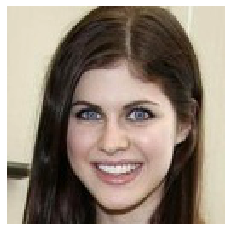

In [2]:
#dataset = 'mnist' # 'mnist' or 'celeba'
dataset = 'celeba'
path = './test_data/' + dataset + '/' 
img_name = dataset + '_128x128' # 1-5 (for celeba), 1-6 (for mnist)
img_path = path + img_name + ".jpg"
img_pil = Image.open(img_path)
#if dataset == 'celeba':
#    img_pil = img_pil.crop((60,80+20,60+64,80+84)) #crop to 3 x 64 x 64
img_np = pil_to_np(img_pil)
print('Dimensions of input image:', img_np.shape)
img_np = img_np / np.max(img_np)
img_np_orig = 1*img_np

if dataset == 'celeba':
    plt.imshow(img_np.transpose(1,2,0))
else:
    plt.imshow(img_np[0,:,:])
    plt.gray()
plt.axis('off')
img_var = np_to_var(img_np).type(dtype)
d = img_np.shape[1]
out_ch = img_np.shape[0]
d_image = img_np.size

G0 = img_var

print(G0)


# 2. Load a pretrained generative model on the dataset (now: PGGAN)

In [4]:
use_gpu = True if torch.cuda.is_available() else False

# trained on high-quality celebrity faces "celebA" dataset
# this model outputs 512 x 512 pixel images
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celeba',
                       pretrained=True, useGPU=use_gpu)
# this model outputs 256 x 256 pixel images
# model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
#                        'PGAN', model_name='celebAHQ-256',
#                        pretrained=True, useGPU=use_gpu)
G = model.netG

Using cache found in /home/jovyan/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


# 3. Compressed sensing using generative models

## 3.1. A=I

In [10]:
mse = torch.nn.MSELoss()

#G0 = G(torch.zeros(1,model.config.noiseVectorDim))

def exp_lr_scheduler(optimizer, epoch, init_lr=0.05, lr_decay_epoch=15, factor=0.7):
    """Decay learning rate by a factor of 0.5 every lr_decay_epoch epochs."""
    lr = init_lr * (factor**(epoch // lr_decay_epoch))
    if epoch % lr_decay_epoch == 0:
        print('\nLR is set to {}'.format(lr))
        print('\n')
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

def fit(G, num_iter = 2000, lr_decay_epoch = 200):
    z = Variable(torch.randn(1,model.config.noiseVectorDim), requires_grad = True)
    optimizer = optim.Adam([z])
    for i in range(num_iter):
        #################
        if lr_decay_epoch is not 0:
            optimizer = exp_lr_scheduler(optimizer, i, init_lr=0.1, lr_decay_epoch=lr_decay_epoch, factor=0.7)
            
        #################
        def closure():
            optimizer.zero_grad()           
            x = G(z)
            loss = mse(x, G0)
            loss.backward(retain_graph=True)
            if i % lr_decay_epoch == 0:
                print('loss = {}'.format(loss))
            return loss

        loss = optimizer.step(closure)
    print('done')
    print('loss = {}'.format(loss))
    #print(z)
    return z


LR is set to 0.1


loss = 0.17675356566905975

LR is set to 0.06999999999999999


loss = 0.08012431114912033
done
loss = 0.07117955386638641


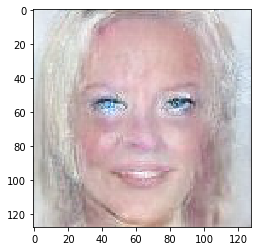

In [13]:
z = fit(G = G, num_iter = 20, lr_decay_epoch = 10)    
    
gen_image = G(z)



grid = torchvision.utils.make_grid(gen_image.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.detach().permute(1, 2, 0).cpu().numpy())

#print(gen_image-G0)

# 3.2. A= Gaussian 

In [ ]:
d_image = G0.numel()

f = 0.2 #compression rate
print('Compression rate is ', f)
m_image = int(f*d_image)
print('Number of measurements is ',m_image, ' for signal of length ', d_image)


# random Gaussian measurement matrix : A

A = torch.randn(m_image, d_image)
x = G0.reshape(d_image)
y = torch.matmul(A,x)
latentDim = model.config.noiseVectorDim

def fit2(G,A,y, d_image, latentDim, num_iter = 2000, lr_decay_epoch = 200):
    z = Variable(torch.randn(1,latentDim), requires_grad = True)
    
    optimizer = optim.Adam([z])
    for i in range(num_iter):
        ############
        if lr_decay_epoch is not 0:
            optimizer = exp_lr_scheduler(optimizer, i, init_lr=0.1, lr_decay_epoch = lr_decay_epoch, factor = 0.7)
        ############
        
        def closure():
            optimizer.zero_grad()
            
            x_var = G(z).reshape(d_image)
            y_var = torch.matmul(A,x_var)
            loss = mse(y_var, y)
            
            loss.backward(retain_graph = True)
            if i % lr_decay_epoch == 0:
                print('loss = {}'.format(loss))
            return loss
        
        loss = optimizer.step(closure)
    return z



In [ ]:
z = fit2(G, A, y, num_iter = 2000, lr_decay_epoch = 200)
x_hat = G(z)

#x_hat.reshape(x.size(0),x.size(1))
grid = torchvision.utils.make_grid(x_hat.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.detach().permute(1, 2, 0).cpu().numpy())

In [ ]:
'''G = model.netG
mse = torch.nn.MSELoss()

G0 = G(torch.zeros(1,model.config.noiseVectorDim))
d_image = G0.numel()
x = G0.reshape(d_image)

f = 0.2 #compression rate
print('Compression rate is ', f)
m_image = int(f*d_image)
print('Number of measurements is ',m_image, ' for signal of length ', d_image)


# random Gaussian measurement matrix : A
A = torch.randn(m_image, d_image)
y = torch.matmul(A,x)

# optimization min ||AG(z)-AG0||
z = Variable(torch.randn(1,model.config.noiseVectorDim), requires_grad = True)
optimizer = optim.Adam([z], lr=0.09)
for t in range(10):
    print('-' * 50)
    optimizer.zero_grad()
    x_var = G(z).reshape(d_image)
    y_var = torch.matmul(A,x_var)
    loss = mse(y_var, y)
    print(t, loss)
    loss.backward(retain_graph=True)
    optimizer.step()
print('end epoch')

x_hat = G(z)
#x_hat.reshape(x.size(0),x.size(1))
grid = torchvision.utils.make_grid(x_hat.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.detach().permute(1, 2, 0).cpu().numpy())
# plt.show()
#print(Ameas.shape)
# measurements : y = A*x
#img_var_meas = torch.matmul(Ameas_var,img_var.to(device).reshape(d_image,1))

'''

In [ ]:
import time
import torch

t0 = time.time()

x = torch.randn(50000)
A = torch.randn(10000,50000)
y = torch.matmul(A,x)

t1 = time.time()
print('\ntime elapsed:',t1-t0)

In [ ]:
'''
optimizer = optim.Adam([z], lr=0.09)
for t in range(10):
    print('-' * 50)
    optimizer.zero_grad()
    x = G(z)
    loss = mse(x,G0)
    print(t, loss)
    loss.backward(retain_graph=True)
    optimizer.step()
print('end epoch')
    
optimizer = optim.Adam([z], lr=0.06)
for t in range(10): 
    print('-' * 50)
    optimizer.zero_grad()
    x = G(z)
    loss = mse(x,G0)
    print(t, loss)
    loss.backward(retain_graph=True)
    optimizer.step()
print('end epoch')

optimizer = optim.Adam([z], lr=0.03)
for t in range(10): 
    print('-' * 50)
    optimizer.zero_grad()
    x = G(z)
    loss = mse(x,G0)
    print(t, loss)
    loss.backward(retain_graph=True)
    optimizer.step()
print('end epoch')

optimizer = optim.Adam([z], lr=0.01)
for t in range(10): 
    print('-' * 50)
    optimizer.zero_grad()
    x = G(z)
    loss = mse(x,G0)
    print(t, loss)
    loss.backward(retain_graph=True)
    optimizer.step()
'''

In [ ]:
t = torch.randn